In [1]:
%config InlineBackend.figure_format = "retina"

In [2]:
import duckdb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

transactions = duckdb.read_csv("../data/transactions.csv")

transactions

┌────────────────────┬──────────────────┬─────────────────────┬─────────┬──────────────────┬────────────────────┐
│     client_id      │ transaction_date │ country_of_purchase │ gender  │    price_full    │ product_collection │
│      varchar       │       date       │       varchar       │ varchar │      double      │      varchar       │
├────────────────────┼──────────────────┼─────────────────────┼─────────┼──────────────────┼────────────────────┤
│ 0011i00000SzBVHAA3 │ 2017-04-10       │ Thailand            │ Male    │ 10121.0147819178 │ Collection 6       │
│ 0011i00000SydhuAAB │ 2015-09-18       │ Malaysia            │ Male    │ 3591.17458743828 │ Collection 6       │
│ 0011i00000Sydm4AAB │ 2015-03-31       │ Malaysia            │ Female  │ 7310.30751894496 │ Collection 6       │
│ 0011i00000SydiFAAR │ 2015-10-09       │ Malaysia            │ Male    │ 9487.76878457763 │ Collection 8       │
│ 0011i00000SycixAAB │ 2015-03-26       │ Malaysia            │ Male    │ 27987.31690135

In [3]:
duckdb.sql(
    """
SELECT
    distinct_country > 1 AS different_distinct_countries,
    COUNT(1) AS total,
    ROUND(AVG(total_transactions), 2) AS avg_total_transactions,
    ROUND(COUNT(1) / SUM(COUNT(1)) OVER () * 100, 1) AS perc_total
FROM (
SELECT
    client_id,
    COUNT(DISTINCT country_of_purchase) distinct_country,
    COUNT(DISTINCT transaction_date) AS total_transactions,
FROM transactions
GROUP BY client_id
)
GROUP BY 1
ORDER BY 1
"""
)

┌──────────────────────────────┬───────┬────────────────────────┬────────────┐
│ different_distinct_countries │ total │ avg_total_transactions │ perc_total │
│           boolean            │ int64 │         double         │   double   │
├──────────────────────────────┼───────┼────────────────────────┼────────────┤
│ false                        │ 52378 │                   1.07 │       99.1 │
│ true                         │   477 │                   2.29 │        0.9 │
└──────────────────────────────┴───────┴────────────────────────┴────────────┘

In [4]:
rfm = duckdb.sql(
    """
SELECT
    client_id,
    DATE_DIFF('DAYS', MAX(transaction_date), DATE '2017-12-31') AS recency,
    COUNT(DISTINCT transaction_date) AS frequency,
    CAST(SUM(price_full) AS INT) AS monetary
FROM transactions
GROUP BY client_id
"""
)

In [5]:
rfm_df = rfm.df().set_index("client_id")

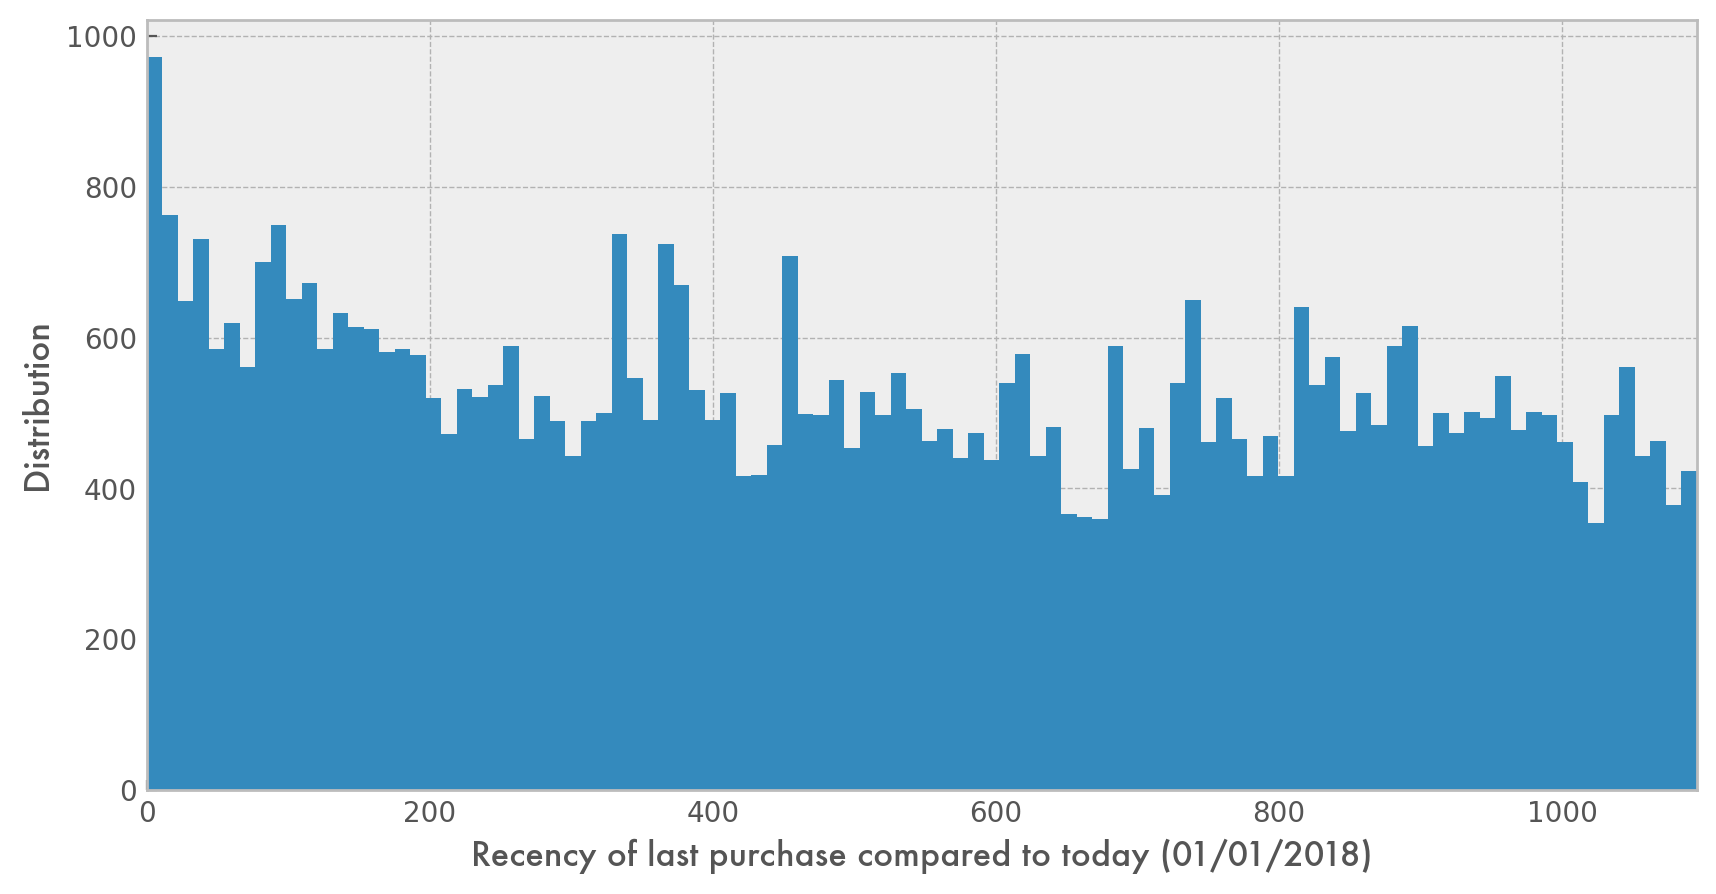

In [24]:
with plt.style.context("bmh"):
    plt.figure(figsize=(10, 5))
    rfm_df.recency.plot.hist(bins=100)
    plt.xlabel(
        "Recency of last purchase compared to today (01/01/2018)", fontname="Futura"
    )
    plt.ylabel("Distribution", fontname="Futura")
    plt.xlim(rfm_df.recency.min(), rfm_df.recency.max())

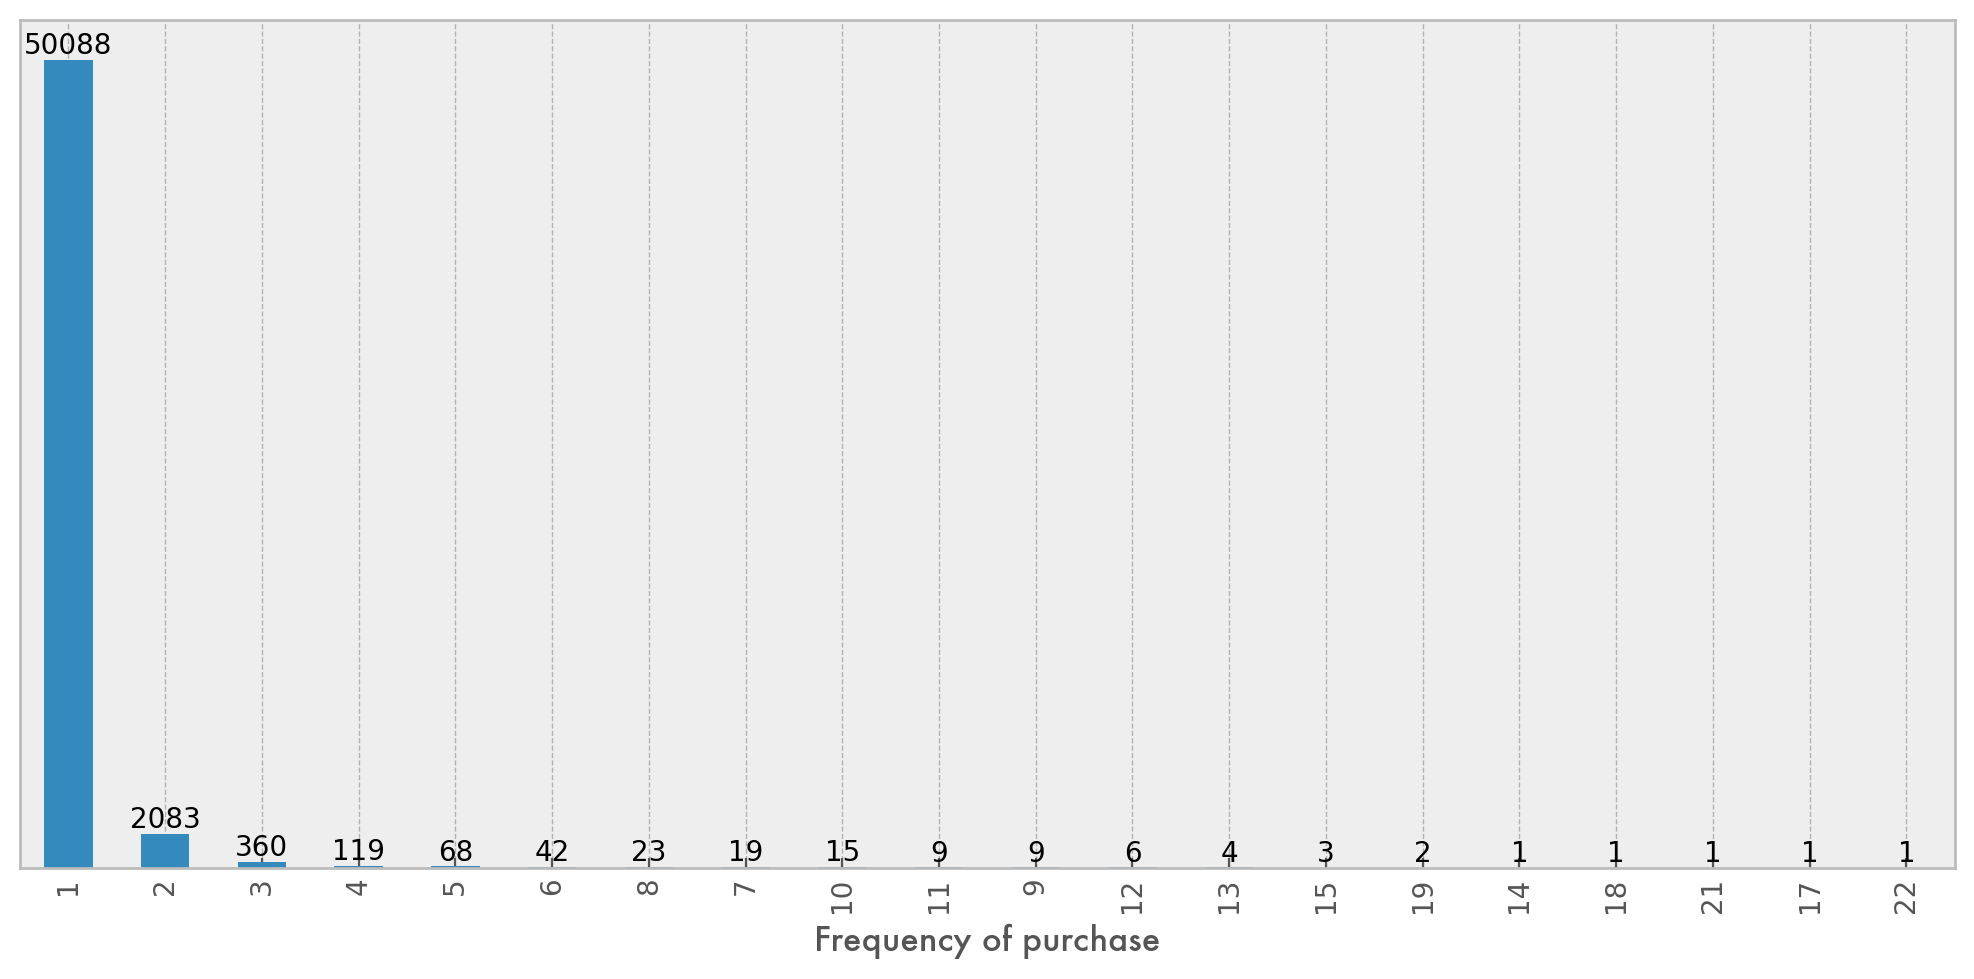

In [38]:
with plt.style.context("bmh"):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax = rfm_df.frequency.value_counts().plot.bar(ax=ax)
    ax.set_xlabel("Frequency of purchase", fontname="Futura")
    ax.set_ylabel("Distribution", fontname="Futura")
    ax.bar_label(ax.containers[0], label_type="edge")
    ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    # plt.xlim(rfm_df.recency.min(), rfm_df.recency.max())

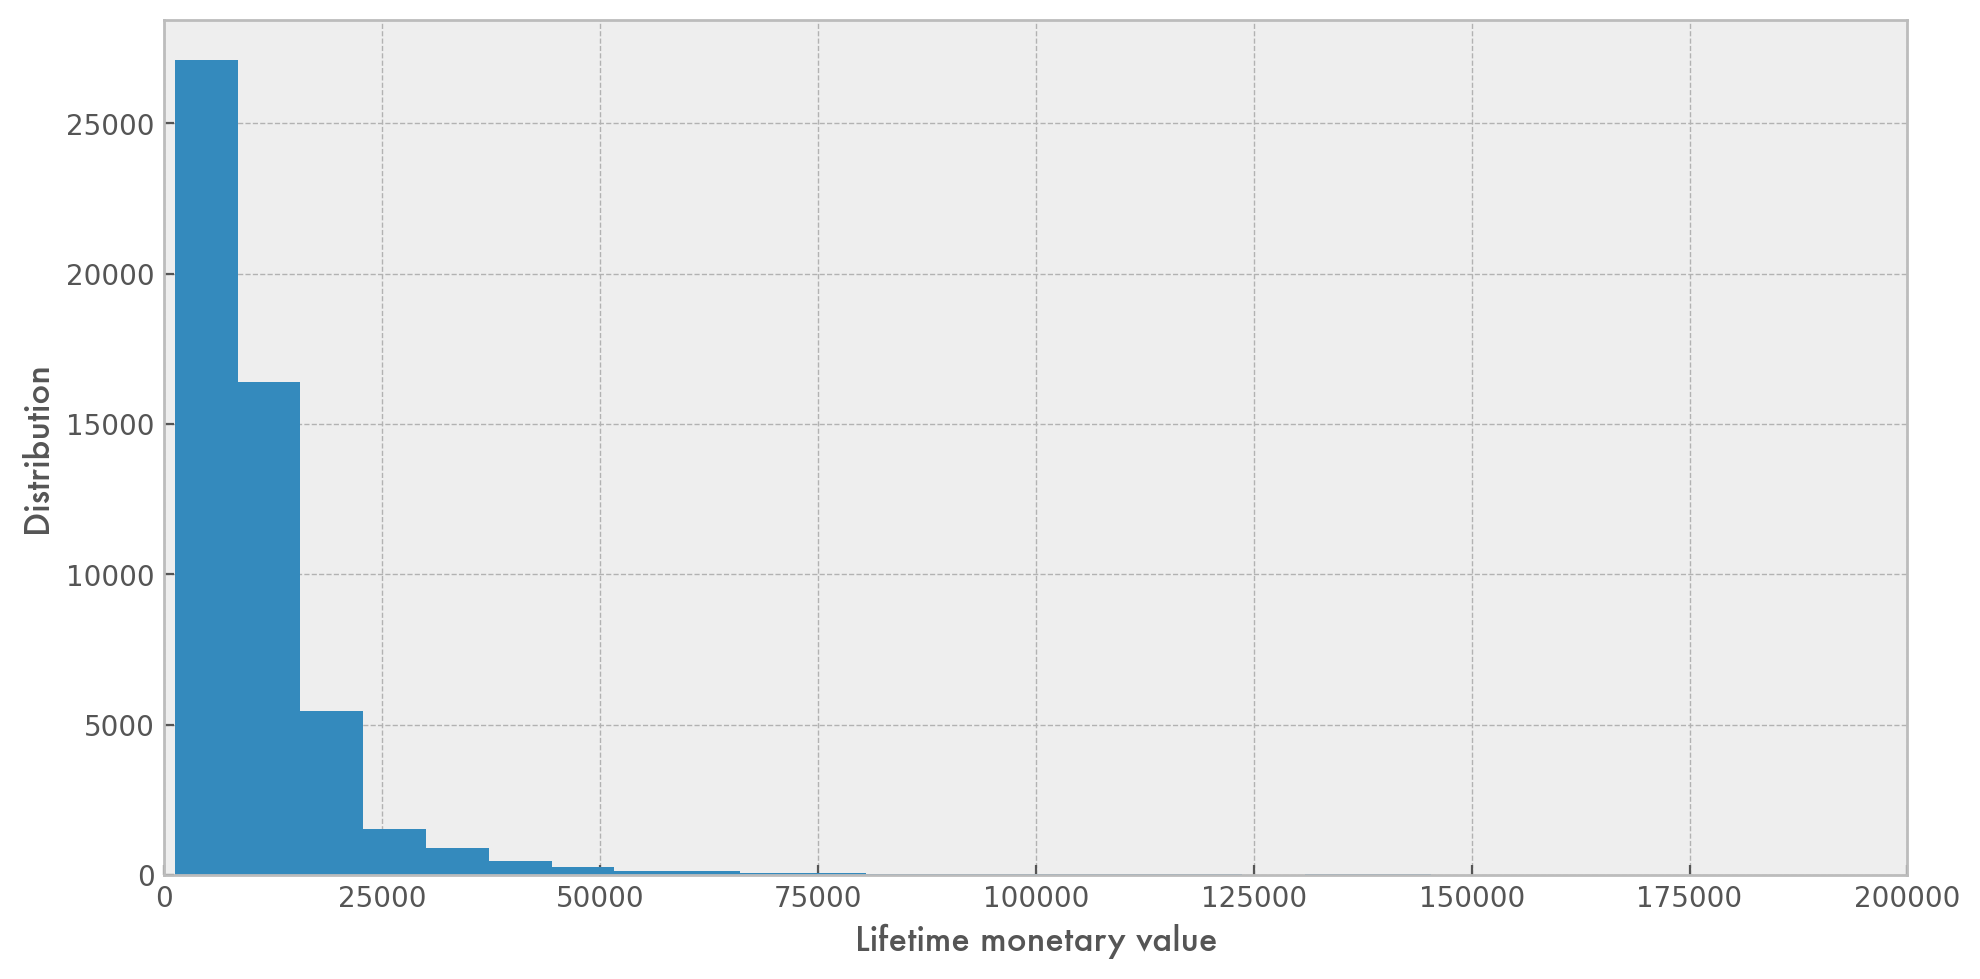

In [50]:
with plt.style.context("bmh"):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax = rfm_df.monetary.plot.hist(bins=200)
    ax.set_xlim(0, 2e5)
    ax.set_xlabel("Lifetime monetary value", fontname="Futura")
    ax.set_ylabel("Distribution", fontname="Futura")
    # ax.bar_label(ax.containers[0], label_type='edge')
    # ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    # plt.xlim(rfm_df.recency.min(), rfm_df.recency.max())

In [51]:
rfm_df_log = rfm_df.assign(
    frequency=lambda x: (x.frequency > 1) * 1 + 1,
    monetary=lambda x: x.monetary.map(np.log),
)

In [52]:
rfm_df_log

,recency,frequency,monetary
client_id,,,
0011i00000SzBVHAA3,265,2,9.911952
0011i00000SycixAAB,1011,2,10.369546
0011i00000S5d1OAAR,195,1,9.056256
0011i00000Y2XhXAAV,155,1,8.486115
0011i00000Sz9sVAAR,688,1,8.430327
...,...,...,...
0011i00000SzOUfAAR,27,1,8.943637
0011i00000YPqOvAAL,1006,1,9.092570
0011i00000YSRPdAAP,707,1,9.470703


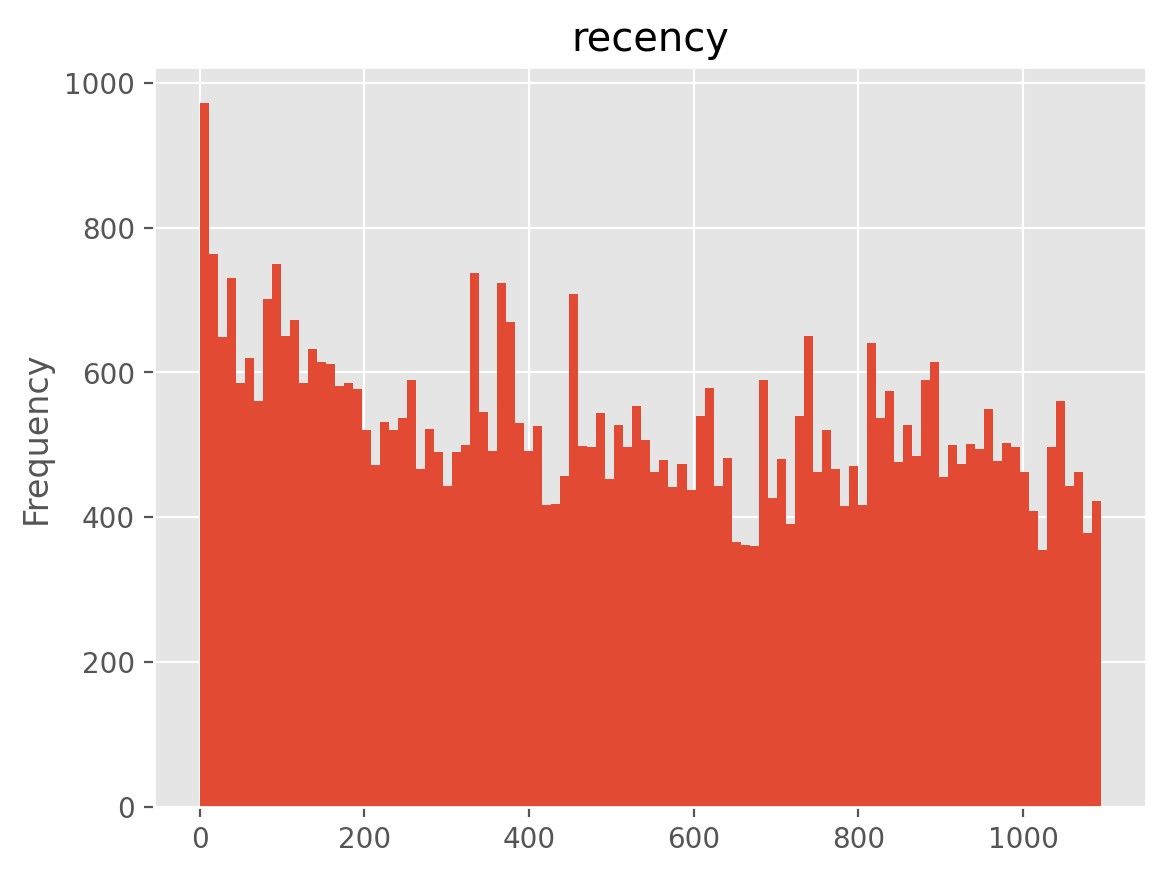

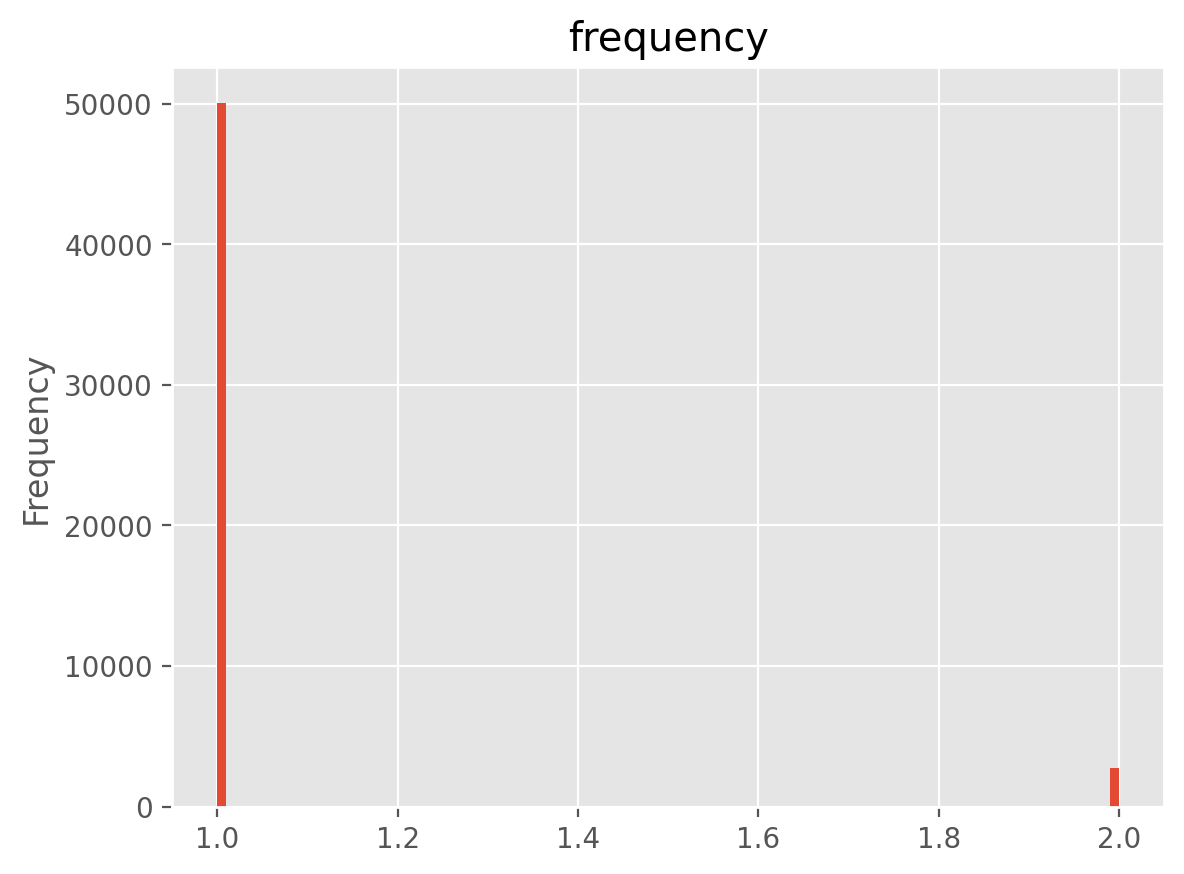

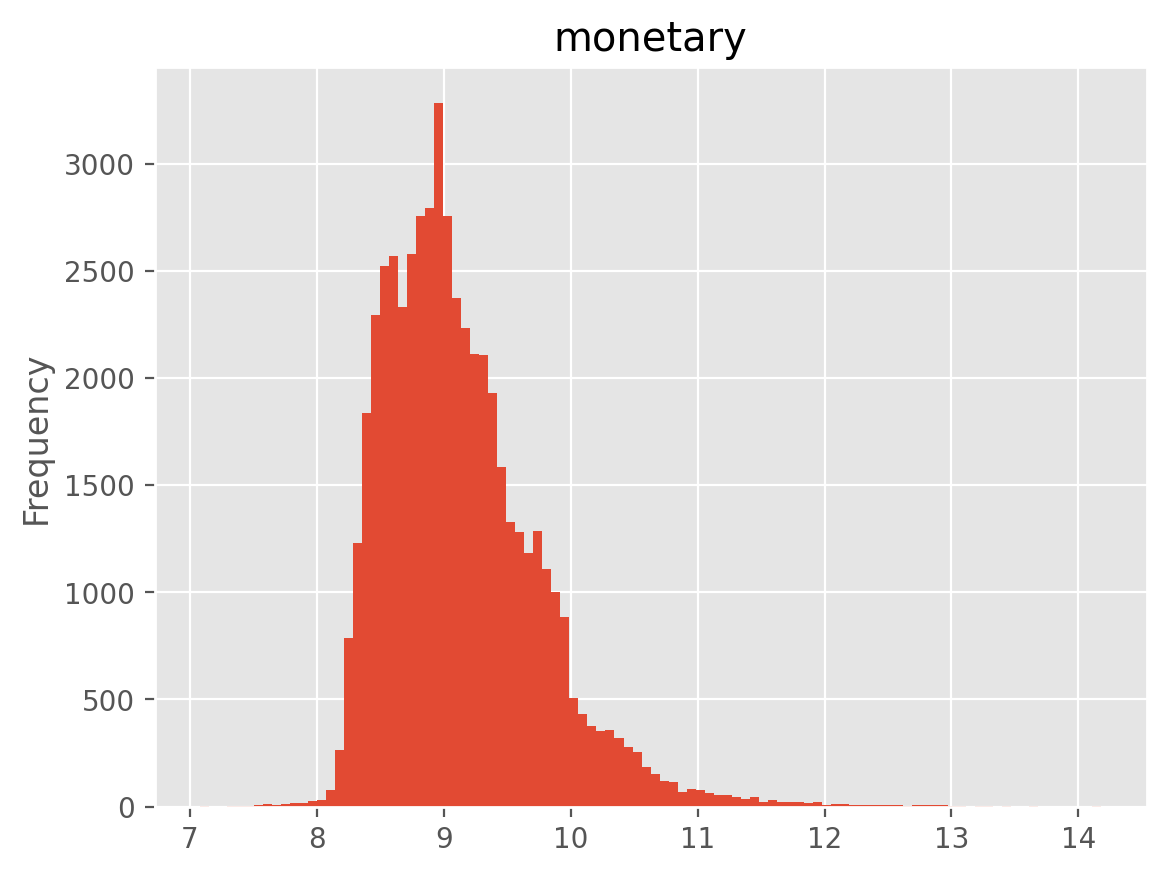

In [53]:
for c in rfm_df_log.columns:
    rfm_df_log.get(c).plot.hist(bins=100)
    plt.title(c)
    plt.show()

## Quantile

In [54]:
rfm_df.quantile(q=[0.2, 0.4, 0.6, 0.8])

,recency,frequency,monetary
0.2,173.0,1.0,5469.0
0.4,385.0,1.0,7327.0
0.6,617.0,1.0,9645.4
0.8,856.0,1.0,14571.6


(0.0, 10.0)

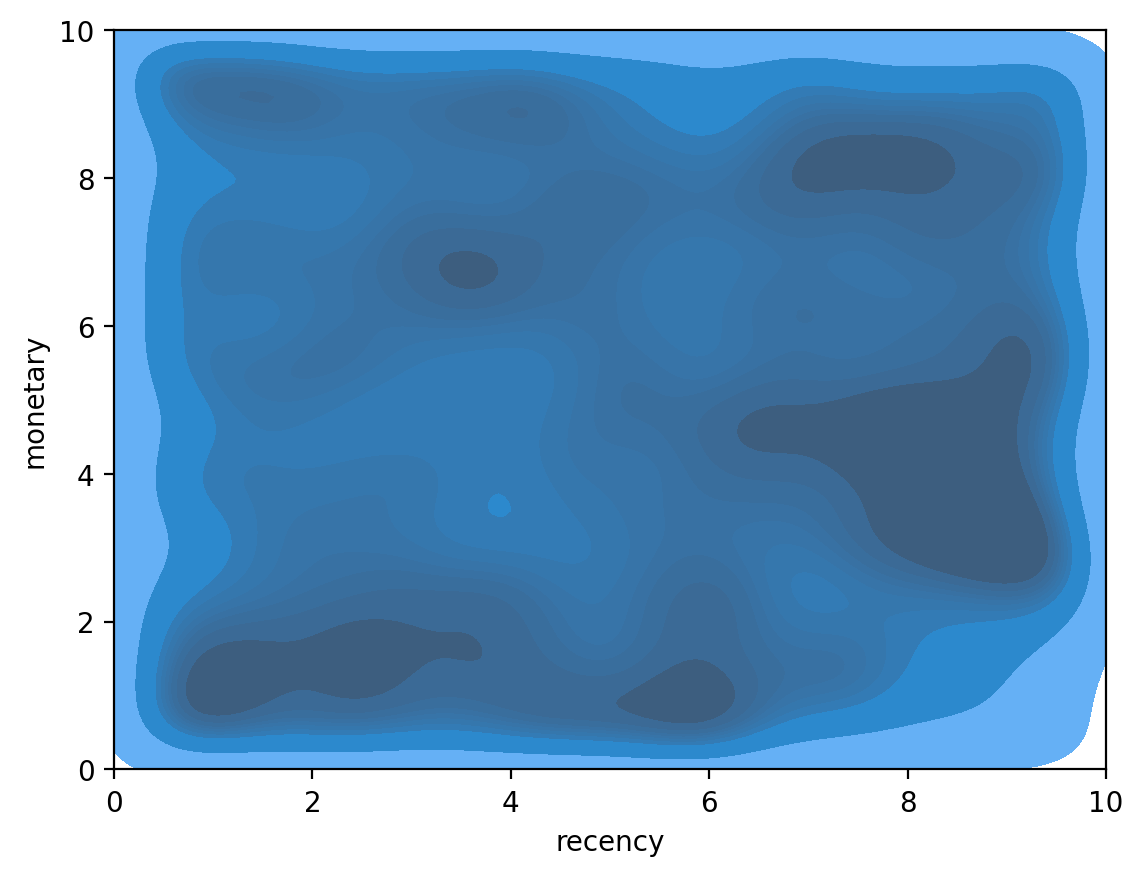

In [19]:
percentile = 10
rfm_df_score = (
    rfm_df.rank(axis=0, pct=True).mul(percentile)
    # .round()
    .assign(
        total_score=lambda x: x.sum(axis=1), fm_score=lambda x: x.frequency + x.monetary
    )
)

sns.kdeplot(
    x=rfm_df_score.recency,
    y=rfm_df_score.monetary,
    fill=True,  # , cmap="Blues", fill=True, thresh=0
)
plt.xlim(0, percentile)
plt.ylim(0, percentile)

## KMeans

In [55]:
from sklearn.preprocessing import StandardScaler

In [56]:
sc = StandardScaler()
rfm_np_scaled = sc.fit_transform(rfm_df)
rfm_df_scaled = pd.DataFrame(rfm_np_scaled, index=rfm_df.index, columns=rfm_df.columns)

In [57]:
rfm_df_scaled.describe()

,recency,frequency,monetary
count,5.285500e+04,5.285500e+04,5.285500e+04
mean,-4.032974e-17,-1.008243e-16,1.828281e-17
std,1.000009e+00,1.000009e+00,1.000009e+00
min,-1.594474e+00,-1.598617e-01,-5.787398e-01
25%,-8.943060e-01,-1.598617e-01,-3.258129e-01
50%,-5.162625e-02,-1.598617e-01,-2.010613e-01
75%,8.901922e-01,-1.598617e-01,3.667277e-02
max,1.797932e+00,3.933253e+01,7.652693e+01


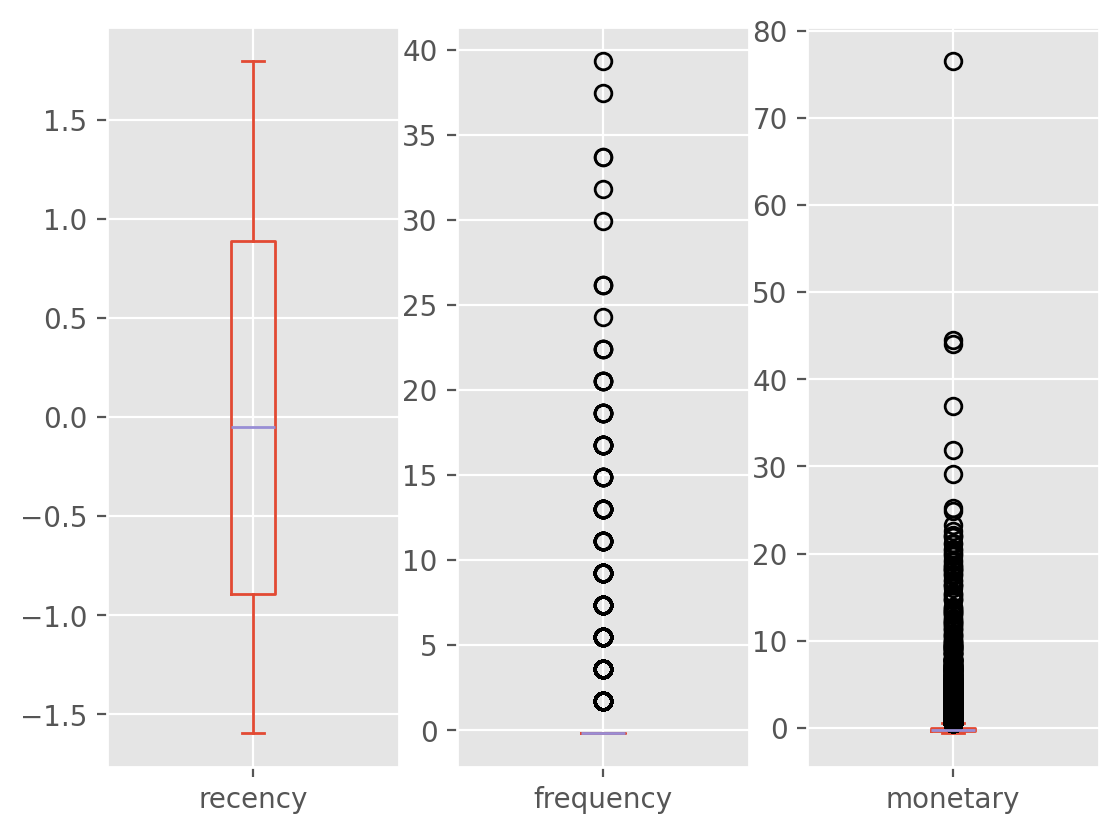

In [58]:
rfm_df_scaled.plot.box(subplots=True)
plt.show()

In [59]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [60]:
min_cluster = 2
max_cluster = 5

random_state = 54

X = rfm_df_scaled.copy()

for n_clusters in range(min_cluster, max_cluster + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)

    cluster_labels = kmeans.fit_predict(X)

    tsne = TSNE(random_state=random_state, verbose=1, n_jobs=-1)

    print("Centroids:")
    display(
        pd.DataFrame(
            sc.inverse_transform(kmeans.cluster_centers_),
            index=[f"cluster_{i}" for i in range(n_clusters)],
            columns=rfm_df_scaled.columns,
        )
    )

Centroids:


,recency,frequency,monetary
cluster_0,245.803058,1.139563,13198.642831
cluster_1,807.066946,1.025672,10701.557605


Centroids:


,recency,frequency,monetary
cluster_0,249.688636,1.079964,11289.332285
cluster_1,812.579032,1.032240,10934.675511
cluster_2,258.921053,5.861842,164300.351974


Centroids:


,recency,frequency,monetary
cluster_0,152.392106,1.107415,11910.018664
cluster_1,501.715084,1.030873,10038.492032
cluster_2,258.921053,5.861842,164300.351974
cluster_3,892.117792,1.032845,11370.193757


Centroids:


,recency,frequency,monetary
cluster_0,150.774771,1.044791,10298.873682
cluster_1,504.025108,1.036063,10182.526440
cluster_2,217.718750,7.710938,249482.742188
cluster_3,893.697187,1.023473,10829.028076
cluster_4,340.980750,2.863222,63049.381966


In [62]:
n_cluste_final = 3

kmeans = KMeans(n_clusters=n_cluste_final, random_state=random_state)

cluster_labels = kmeans.fit_predict(X)

tsne = TSNE(random_state=random_state, verbose=1, n_jobs=-1)

print("Centroids:")
display(
    pd.DataFrame(
        sc.inverse_transform(kmeans.cluster_centers_),
        index=[f"cluster_{i}" for i in range(n_cluste_final)],
        columns=rfm_df_scaled.columns,
    )
)

Centroids:


,recency,frequency,monetary
cluster_0,249.688636,1.079964,11289.332285
cluster_1,812.579032,1.032240,10934.675511
cluster_2,258.921053,5.861842,164300.351974


In [64]:
from collections import Counter

In [65]:
Counter(cluster_labels)

Counter({0: 27693, 1: 24858, 2: 304})

In [73]:
X.assign(cluster=cluster_labels).reset_index().to_gbq(
    "richemont.rfm_cluster", project_id="lgrosjean"
)

100%|██████████| 1/1 [00:00<00:00, 3086.32it/s]
